In [1]:
!pip install -q transformers

In [2]:
!pip install -q datasets

In [3]:
!pip install -q huggingface_hub

In [4]:
!pip search espeak
!pip install py-espeak-ng
!sudo apt-get install python-espeak
!sudo apt-get update && sudo apt-get install espeak

ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI's XMLRPC API is currently disabled due to unmanageable load and will be deprecated in the near future. See https://status.python.org/ for more information.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-espeak is already the newest version (0.5-1build5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.
Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://

In [5]:
!pip install -q phonemizer

In [6]:
import soundfile as sf
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import re
import zipfile
import pandas as pd
import phonemizer
import random
import spacy
import nltk
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from huggingface_hub import hf_hub_download
from datasets import load_dataset
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2Tokenizer, Wav2Vec2Config
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score

In [7]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
config = Wav2Vec2Config.from_pretrained("facebook/wav2vec2-xlsr-53-espeak-cv-ft", output_hidden_states=True)
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-xlsr-53-espeak-cv-ft", config=config)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-xlsr-53-espeak-cv-ft")

### Первый этап: сбор данных

В датасете TIMIT для каждой аудиозаписи можно найти ещё три файла: 
- .phn - файл, в котором на каждой строке выписаны начало и конец произнесения звука и сам звук
- .wrd - файл, в котором на каждой строке выписаны начало и конец произнесения слова и само слово
- .wav - файл аудиозаписи

In [9]:
# importing necessary modules
import requests, zipfile
from io import BytesIO
print('Downloading started')

#Defining the zip file URL
url = 'https://data.deepai.org/timit.zip'

# Split URL to get the file name
filename = url.split('/')[-1]

# Downloading the file by sending the request to the URL
req = requests.get(url)
print('Downloading Completed')

# extracting the zip file contents
my_zipfile= zipfile.ZipFile(BytesIO(req.content))
#zipfile.extractall()

In [10]:
needed_files = [file for file in my_zipfile.namelist() if file.endswith('.wav')]

В переменной *vocab* хранится словарь, где каждому звуку соответствует его индекс в векторе. Так как для дальнейшей работы удобнее сделать так, чтобы ключом был индекс, а значением звук, что сохранено в переменной *convenient_vocab*.

In [11]:
_file = hf_hub_download(repo_id="facebook/wav2vec2-xlsr-53-espeak-cv-ft", filename="vocab.json")
with open(_file, 'r') as f:
  vocab = json.loads(f.read())

In [12]:
convenient_vocab = {}
for k, v in vocab.items():
  convenient_vocab[v] = k

Следующие две функции создают списки, в которых можно найти:
1. Начало и конец звучания слова
2. Само слово
3. Следующее после него слово.

Функция *find_s* ищет все слова, которые оканчиваются на букву *s*, не являющейся клитикой посессивности.

Функция *find_t* ищет все слова, которые оканчиваются на -ed или имеют звук [t].

In [13]:
def find_phoneme(filename):
  with my_zipfile.open(filename, 'r') as f:
    lines = f.readlines()
    phonemes_words = []
    for i in range(len(lines)-1):
      bgn, end, word = lines[i].split() 
      next_word = lines[i+1].split()[-1].decode("utf-8")
      bgn = int(bgn.decode("utf-8"))
      end = int(end.decode("utf-8"))
      word = word.decode("utf-8")
      if word.endswith('s') and "'" not in word:
        phonemes_words.append([bgn, end, word, next_word])
    return phonemes_words

In [14]:
def find_new_phoneme(filename):
  with my_zipfile.open(filename, 'r') as f:
    lines = f.readlines()
    phonemes_words = []
    for i in range(len(lines)-1):
      bgn, end, word = lines[i].split()
      next_word = lines[i+1].split()[-1].decode("utf-8")
      bgn = int(bgn.decode("utf-8"))
      end = int(end.decode("utf-8"))
      word = word.decode("utf-8")
      ind = word.find('t')
      if ((ind != -1) and (ind != len(word)-1)) or (word.endswith('ed')):
        phonemes_words.append([bgn, end, word, next_word])
    return phonemes_words

Следующие две ячейки собирают данные для каждого из тестов на фонемы. В каждом из них проверяется, чтобы не происходило частичных ассимиляций по звонкости.

Для данных на фонемы /t/ и /d/ идёт проверка на то, чтобы в написании слова не встречались буквы s и t рядом, так как подобное сочетание часто прочитывается так, что влияет на реализацию [t].

In [15]:
all_words_arrays = []
for filename in tqdm(needed_files):
  if '.wav' in filename:
    with my_zipfile.open(filename) as f:
      audio, sample_rate = sf.read(f)
      audio = audio.astype(np.float64)
      audio = audio / np.max(np.abs(audio))
    wrd_file=filename.replace(".WAV.wav",".WRD")
    wrd_sig=find_phoneme(wrd_file)
    for word in wrd_sig:
      if (word[3][0] in ['p', 't', 'h', 'c', 'f', 'k', 's']) and \
      (word[2][-2] in ['p', 't', 'h', 'c', 'f', 'k', 's', 'a', 'e', 'u', 'o', 'i']):
        word_phoneme = {
            word[2]: {
                'audio': audio[word[0]:word[1]], 
                'sample_rate': sample_rate
                }
              }
        all_words_arrays.append(word_phoneme)

100%|██████████| 6300/6300 [00:29<00:00, 210.76it/s]


In [16]:
all_words_arrays_t = []
for filename in tqdm(needed_files):
  if '.wav' in filename:
    with my_zipfile.open(filename) as f:
      audio, sample_rate = sf.read(f)
      audio = audio.astype(np.float64)
      audio = audio / np.max(np.abs(audio))
    wrd_file=filename.replace(".WAV.wav",".WRD")
    wrd_sig=find_new_phoneme(wrd_file)
    for word in wrd_sig:
      ind = word[2].find('t')
      if ind != -1:
        if (word[2][ind-1] == 's' and ind != 0) or (word[2][ind+1] == 's'):
          word_phoneme = {
            word[2]: {
                'audio': audio[word[0]:word[1]], 
                'sample_rate': sample_rate
                }
              }
          all_words_arrays_t.append(word_phoneme)
      if (word[2].endswith('ed')) and (word[2][-3] in ['p', 't', 'h', 'c', 'f', 'k', 's']):
        word_phoneme = {
            word[2]: {
                'audio': audio[word[0]:word[1]], 
                'sample_rate': sample_rate
                }
              }
        all_words_arrays_t.append(word_phoneme)

100%|██████████| 6300/6300 [00:35<00:00, 178.61it/s]


Функция *all_vectors* записывает вектора звуков, а также слова, в которых встретились нужные звуки. Переменная *testname* контролирует тест, для которого на данный момент собираются данные.

In [17]:
def all_vectors(n, layer, predicted_ids, word, testname): #, next_word):
  numpy_logits = layer[0].detach().numpy()
  for i in range(len(predicted_ids[0])):
    if predicted_ids[0][i] not in [1, 2, 3, 0]:
      all_sound_vectors[testname][n][convenient_vocab[predicted_ids[0][i]]].append(numpy_logits[i])
    if n == 0:
      if testname == 'z':
        if (convenient_vocab[predicted_ids[0][i]] == 's') or \
                    (convenient_vocab[predicted_ids[0][i]] == 'z'):
          words[convenient_vocab[predicted_ids[0][i]]].append(word)
    elif testname == 't':
      if (convenient_vocab[predicted_ids[0][i]] == 't') or \
                  (convenient_vocab[predicted_ids[0][i]] == 'd'):
        words_t[convenient_vocab[predicted_ids[0][i]]].append(word)

In [18]:
all_sound_vectors = {'z': [defaultdict(list) for i in range(26)], 't': [defaultdict(list) for i in range(26)]}
all_near_sounds = defaultdict(list)
words_t = {'t': [], 'd': []}
words = {'z': [], 's': []}
layers = []
all_keys = []

In [19]:
testname = 'z'  # 'z' or 't'
for testname in ['t', 'z']:
  if testname == 'z':
    arrays = all_words_arrays
  else:
    arrays = all_words_arrays_t
  for audio in tqdm(arrays):
    key = list(audio.keys())[0]
    all_keys.append(key)
    audio_input = audio[key]['audio']
    sample_rate = audio[key]['sample_rate']
    input_values = processor(audio_input, 
                            sampling_rate=sample_rate, 
                            return_tensors="pt").input_values
    with torch.no_grad():
      outputs = model(input_values.float())
      logits = outputs.logits
      hidden_states = outputs.hidden_states
      layers.extend(hidden_states)
      layers.append(logits)
    predicted_ids = torch.argmax(logits, dim=-1).detach().numpy()
    for n, layer in enumerate(layers):
      all_vectors(n, layer, predicted_ids, key, testname)
    layers = []

100%|██████████| 1196/1196 [09:35<00:00,  2.08it/s]


In [20]:
nlp = spacy.load("en_core_web_sm")

### Второй этап: обработка данных и тесты

- *is_plural_wn* получает на вход слово и определяет часть речи и, если слово - существительное, число. Значение 'hello' используется для слов, которые не подходят для теста.

- *is_past* получает на вход слово и определяет, является ли полученное слово глаголом в прошедшем времени.

- *count_accuracy* получает на вход слова, вектора нужных звуков, которые входят в соответствующие слова и список звуков. Внутри функции создаётся таблица, где в каждоей строке есть вектор звука, слово и обозначение звука. Дальше применяется описанные функции и очищаются данные. После на этих данных считается метрика accuracy в двух случаях: на верных данных и на перемешанных.

In [21]:
def is_plural_wn(noun):
  word = nlp(noun)
  mistakes = ['is', 'was', 'has', 
              'this', 'as', 'his', 
              'does', 'themselves', 'requires', 
              'contains']
  if str(word[0]) in mistakes:
    return 'hello'
  if word[0].pos_ == 'NOUN':
    wnl = WordNetLemmatizer()
    lemma = wnl.lemmatize(noun, 'n')
    plural = 1 if noun is not lemma else 0
    return plural
  else:
     return 'hello'

In [22]:
def is_past(word):
  nlp_word = nlp(word)
  if nlp_word[0].pos_ == 'VERB':
    wnl = WordNetLemmatizer()
    lemma = wnl.lemmatize(word, 'v')
    if word != lemma:
      if word.endswith('ed'):
        return 1
    return 0
  else:
     return 0

In [67]:
def count_accuracy(words, emb, sounds, layer):
  random.seed(333)
  data = pd.DataFrame({'word': words, 'vector_emb': emb, 'sound': sounds})
  if 's' in sounds:
    func = is_plural_wn
    data['is'] = data['word'].apply(func)
    res = data[data['is']!='hello'].copy()
    del_words = ['solves', 'tastes', 'celebrates', 
                 'misperceives', 'chases', 'decides', 
                 'involves', 'presumes', 'presents', 
                 'guarantees', 'sets', 'serves', 
                 'causes', 'increases', 'preserves', 
                 'slips', 'prints']
    res = res[~res['word'].isin(del_words)]
  elif 't' in sounds:
    mistakes = ['mopped', 'slanted', 'squeaked', 'invoked', 
                'shocked', 'unfenced', 'crooked', 'uninterrupted', 
                'melted', 'pumped', 'engulfed', 'advanced', 
                'unabashed', 'addressed', 'tilted', 'chorused', 'polished']
    func = is_past
    data['is'] = data['word'].apply(func)
    res = data.copy()
    for m in mistakes:
      res.loc[res['word']==m, 'is_past'] = 1
  answers = [i for i in res['is'].tolist()]
  random.shuffle(answers)

  model_log = LogisticRegression(max_iter=10000)
  X_train, X_test, y_train, y_test = train_test_split(
                                      res['vector_emb'].tolist(), 
                                      res['is'].tolist(), 
                                      train_size = .8, 
                                      random_state=10)
  under_sampler = RandomUnderSampler(random_state=42)
  X_res, y_res = under_sampler.fit_resample(X_train, y_train)
  model_log.fit(X_res, y_res)
  score = model_log.score(X_test, y_test)
  
  model_rn = LogisticRegression(max_iter=10000)
  X_train, X_test, y_train, y_test = train_test_split(
                                      res['vector_emb'].tolist(), 
                                      answers, 
                                      train_size = .8, 
                                      random_state=10)
  under_sampler = RandomUnderSampler(random_state=42)
  X_res, y_res = under_sampler.fit_resample(X_train, y_train)
  model_rn.fit(X_res, y_res)
  rn_score = model_rn.score(X_test, y_test)

  means = None
  if layer == 25:
    means = res.groupby('is')['vector_emb'].agg(np.mean).reset_index()

  return score, rn_score, model_log.coef_[0], means

In [68]:
scores = {'t': [], 'z': []}
rn_scores = {'t': [], 'z': []}
coefs = {'t': [], 'z': []}
means = {'t': [], 'z': []}

In [69]:
for testname in ['t', 'z']:
  if testname == 't':
    all_words = words_t['t'][:1474]
    all_sounds = ['t']*len(all_words)
  elif testname == 'z':
    s_words = words['s']
    z_words = words['z']
    all_words = s_words + z_words
    s_sounds = ['s']*len(s_words)
    z_sounds = ['z']*len(z_words)
    all_sounds = s_sounds + z_sounds
  for i in tqdm(range(26)):
    if testname == 't':
      all_emb = all_sound_vectors[testname][i]['t']
    elif testname == 'z':
      all_emb = all_sound_vectors[testname][i]['s'] + all_sound_vectors[testname][i]['z']
    score, rn_score, coef, mean = count_accuracy(all_words, all_emb, all_sounds, i)
    scores[testname].append(score)
    rn_scores[testname].append(rn_score)
    coefs[testname].append(coef)
    means[testname].append(mean)

100%|██████████| 26/26 [02:58<00:00,  6.87s/it]


### Третий этап: визуализация

Функция для изображения данных:

- draw_coefs рисует графики наибольших по модулю коэффициентов модели.
- draw_accuracy рисует график значений accuracy на каждом слое.


In [56]:
def draw_coefs(coefss, testname):
  '''
  testname -> название теста
  '''
  all_coefs = np.argsort(coefss)
  need_coefs = all_coefs[:10].tolist() + all_coefs[-10:].tolist()
  sounds = []
  coefs = []
  for coef in need_coefs:
    sounds.append(convenient_vocab[coef])
    coefs.append(coefss[coef])
  plt.figure(figsize=(7, 5))
  plt.bar(sounds, coefs)
  plt.xlabel('Звуки')
  plt.ylabel('Коэффициенты')
  plt.title(f'Звуки с наибольшими и наименьшими коэффициентами\nлогистической регрессии, тест: {testname}')

In [40]:
def draw_accuracy(dict_of_scores):
  '''
  dict_of_scores -> словарь, в котором ключом является тип перемешивания,
  а значением список значений accuracy
  '''
  xs = [i for i in range(1, 27)]
  for k, v in dict_of_scores.items():
    plt.plot(xs, v, label=k)
  plt.legend()
  plt.title('Accuracy предсказания звонкости звука на каждом из слоёв')
  plt.xlabel('Номер слоя')
  plt.ylabel('Значение accuracy')

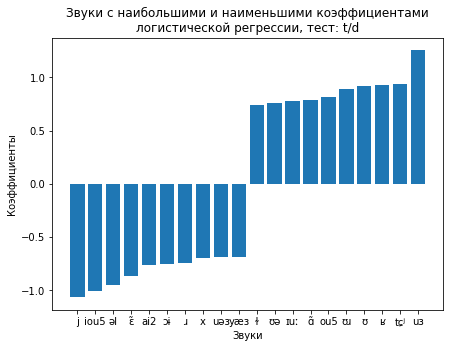

In [70]:
draw_coefs(coefs['t'][-1], 't/d')

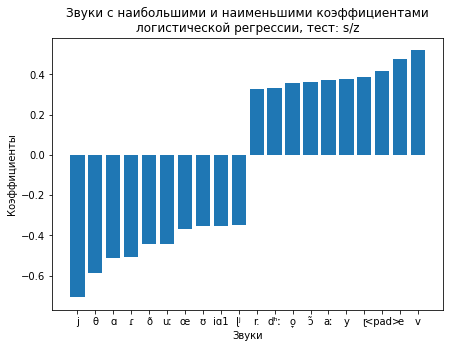

In [71]:
draw_coefs(coefs['z'][-1], 's/z')

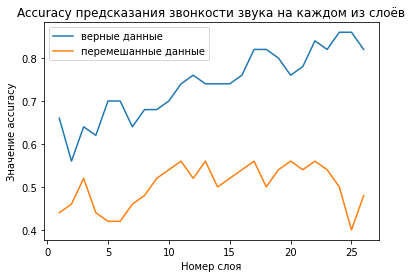

In [72]:
dict_of_accuracies = {'верные данные': scores['z'],
                      'перемешанные данные': rn_scores['z']}
draw_accuracy(dict_of_accuracies)

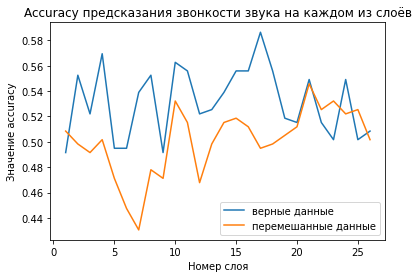

In [73]:
dict_of_accuracies = {'верные данные': scores['t'],
                      'перемешанные данные': rn_scores['t']}
draw_accuracy(dict_of_accuracies)

In [77]:
all_coefs = np.argsort(coefs['z'][-1])
need_coefs = all_coefs[:10].tolist() + all_coefs[-10:].tolist()
for i, row in means['z'][-1].iterrows():
  sort_means = row['vector_emb'][need_coefs]
  print(sort_means)

[ 0.16576631  1.893232   -1.3382057   0.34422153  0.68454254 -1.3252984
 -3.9671395   0.19938576 -6.4546165  -3.8163397  -4.9906764  -6.2844005
 -2.804671   -3.6121643  -1.0547712  -2.2729445  -3.221101    5.0351315
  0.28212494 -0.6861569 ]
[ 0.02867408  1.036909   -1.4947692  -0.16158703  0.60225147 -0.8168242
 -3.6220188   0.04277932 -6.32043    -3.3545952  -4.807722   -6.027023
 -2.3103516  -3.3344033  -1.1633655  -1.6131941  -2.7017813   5.146042
  0.2872753  -0.05444616]


In [78]:
all_coefs = np.argsort(coefs['t'][-1])
need_coefs = all_coefs[:10].tolist() + all_coefs[-10:].tolist()
for i, row in means['t'][-1].iterrows():
  sort_means = row['vector_emb'][need_coefs]
  print(sort_means)

[-0.88366246 -4.249467   -2.7619615  -3.7307987  -3.8531613  -3.9654243
 -0.5646247  -1.6397697  -4.3261504  -4.10005    -1.6796534  -5.109337
 -6.058128   -3.2153769  -4.3550725  -4.133974   -1.0103716  -1.677179
 -4.537301   -3.929255  ]
[-0.8908896  -4.255493   -2.7831829  -3.7272387  -3.8523984  -3.9878716
 -0.62012994 -1.6441835  -4.3324327  -4.109496   -1.666898   -5.0996313
 -6.04267    -3.1925607  -4.3505855  -4.13172    -1.0071392  -1.6834451
 -4.5148983  -3.91818   ]
